#### Random Forests, Smote Technique, Hyperparameter Optimization with GridSearchCV and Feature Importance 

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix   
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks


import warnings
warnings.filterwarnings('ignore')

In [34]:
data = pd.read_csv("Customer-Churn.csv")
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


In [35]:
data.shape

(7043, 16)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Contract          7043 non-null   object 
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7043 non-null   object 
 15  Churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

In [37]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [38]:
#data['SeniorCitizen']=data['SeniorCitizen'].astype(str)

In [39]:
data.isna().sum().to_frame().rename(columns={0:'count'}).sort_values(by='count', ascending=False)

#TotalCharges column as 11 nulls.

,count
TotalCharges,11
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
OnlineSecurity,0
OnlineBackup,0
DeviceProtection,0


In [40]:
# Replace Nulls with mean
data['TotalCharges'].fillna(int(data['TotalCharges'].mean()), inplace=True)

# OR drop ROWS with nulls since it's only 11 rows.
#data = data.dropna()

### 1. Apply the Random Forests algorithm by upscaling the data using SMOTE.

SMOTE Technique: Random creation of a fake sample. Compute the k-nearest neighbors (for some pre-specified k) for this point. If a k-nn predicts this fake sample to belong to the minority class, keep it, otherwise throw it away.



In [41]:
data.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

We can see skewed class proportions. Majority class is "No" with 5174 values against only 1869 of "Yes" values. 
Our model will be biased towards the majority class if we use this imbalanced data!! It can be problematic especially when we are interested in the prediction of the minority class.

<AxesSubplot:xlabel='Churn', ylabel='count'>

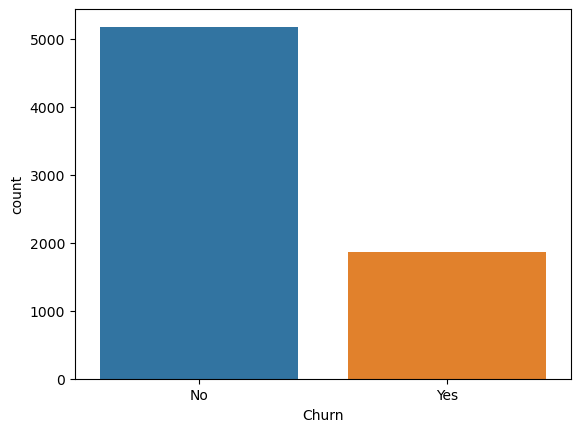

In [42]:
sns.countplot(data["Churn"])

#### Encode the categorical variables first

In [43]:
data2 = pd.get_dummies(data, columns=['gender', 'Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract'])
data2.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year
0,0,1,29.85,29.85,No,1,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0
1,0,34,56.95,1889.50,No,0,1,1,0,1,...,0,1,0,0,1,0,0,0,1,0
2,0,2,53.85,108.15,Yes,0,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0
3,0,45,42.30,1840.75,No,0,1,1,0,1,...,1,1,0,0,1,0,0,0,1,0
4,0,2,70.70,151.65,Yes,1,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0


In [44]:
#... and normalize our numerical columns

numerical=data.select_dtypes(np.number)
numerical=numerical.drop("SeniorCitizen", axis=1)
numerical.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


In [45]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler().fit(numerical)
data_normalized = transformer.transform(numerical)
data_normalized = pd.DataFrame(data_normalized, columns=numerical.columns)
data_normalized.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,0.449599,0.462803,0.261309
std,0.341104,0.299403,0.261366
min,0.000000,0.000000,0.000000
25%,0.125000,0.171642,0.044245
50%,0.402778,0.518408,0.159445
75%,0.763889,0.712438,0.434780
max,1.000000,1.000000,1.000000


In [46]:
data2[['tenure','MonthlyCharges','TotalCharges']] = data_normalized[['tenure','MonthlyCharges','TotalCharges']]
data2.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,0.449599,0.462803,0.261309,0.495244,0.504756,0.516967,0.483033,0.700412,0.299588,...,0.290217,0.398978,0.216669,0.384353,0.395428,0.216669,0.387903,0.550192,0.209144,0.240664
std,0.368612,0.341104,0.299403,0.261366,0.500013,0.500013,0.499748,0.499748,0.458110,0.458110,...,0.453895,0.489723,0.412004,0.486477,0.488977,0.412004,0.487307,0.497510,0.406726,0.427517
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.125000,0.171642,0.044245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.402778,0.518408,0.159445,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.763889,0.712438,0.434780,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
X = data2.drop(["Churn"], axis = 1)
y = data2["Churn"]

### Baseline Model before upsampling data with SMOTE.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [57]:
def different_models(models):
    
    model = models
    model.fit(X_train,y_train) 
    #predictions
    predictions = model.predict(X_test)
    #metrics for evaluation
    print("The accuracy of the model is: {:4.2f}".format(model.score(X_test, y_test)*100))
    print(confusion_matrix(y_test, predictions)) 
    print(classification_report(y_test, predictions))
    plot_confusion_matrix(model, X_test, y_test)  
    plt.show()

The accuracy of the model is: 83.03
[[1273  301]
 [ 226 1305]]
              precision    recall  f1-score   support

          No       0.85      0.81      0.83      1574
         Yes       0.81      0.85      0.83      1531

    accuracy                           0.83      3105
   macro avg       0.83      0.83      0.83      3105
weighted avg       0.83      0.83      0.83      3105



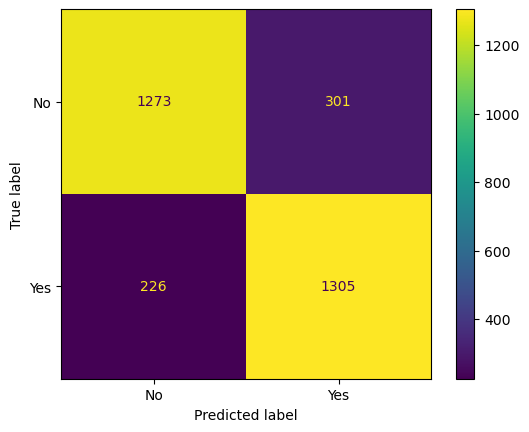

In [62]:
different_models(RandomForestClassifier())

In [50]:
smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

No     5174
Yes    5174
Name: Churn, dtype: int64

In [63]:
# Random Forests algorithm with SMOTE

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3)
model=RandomForestClassifier()
model.fit(X_train,y_train) 
predictions = model.predict(X_test)
print("The accuracy of the model is: {:4.2f}".format(model.score(X_test, y_test)*100))
print(confusion_matrix(y_test, predictions)) 
print(classification_report(y_test, predictions))

The accuracy of the model is: 82.58
[[1234  302]
 [ 239 1330]]
              precision    recall  f1-score   support

          No       0.84      0.80      0.82      1536
         Yes       0.81      0.85      0.83      1569

    accuracy                           0.83      3105
   macro avg       0.83      0.83      0.83      3105
weighted avg       0.83      0.83      0.83      3105



Accuracy improved with SMOTE technique for upsampling data (From 78% to  83%)

### Model Evaluation

#### Using Cross-validation technique to evaluate accuracy of RandomForestClassifier model and test its performance 

"Cross validation is a technique to measure the performance of a model through resampling. Cross validation repeatedly splits the dataset into different training and testing sets. Since cross validation ensures that all observations appear in the training and testing sets, the evaluation metric is considered to be more reliable."

"Cross Validation it helps to compare and select an appropriate model for the specific predictive modeling problem, it gives a better understanding of model performance over the whole dataset instead of just a single train/test split."

In [26]:
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
scores

array([0.81655172, 0.80413793, 0.83172414, 0.8038674 , 0.80939227,
       0.82320442, 0.80662983, 0.82596685, 0.8218232 , 0.83149171])

In [27]:
from scipy.stats import norm

lower, upper = norm.interval(alpha=0.9, loc=np.mean(scores), scale=np.std(scores))
print('lower=%.3f, upper=%.3f' % (lower, upper))

lower=0.800, upper=0.834


I can say with 90% of confidence that the accuracy of the model is between 0.80 and 0.83, which is acceptable but I am going to try and improve it by optimizing with hyperparameter tuning.

In [28]:
np.std(scores), np.mean(scores), min(scores), max(scores)

(0.010345025045419063,
 0.8174789483711183,
 0.8038674033149171,
 0.8317241379310345)

In [ ]:
#print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

###  Hyperparameter Tuning: Optimizing model with GRID SEARCH

In [23]:
#Let's perform Hyperparameter Tuning to see if we get a bettter accuracy.


# dictionary with parameters to put inside the grid for the search space.
param_grid = {
    'criterion': ['gini', 'entropy'],  #The function to measure the quality of a split
    'n_estimators': [50, 100], #The number of trees in the forest.
    'min_samples_split': [2, 4],  #The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 5], #The minimum number of samples required to be at a leaf node.
    'max_features': ['sqrt', 'auto', 'log2'], #The number of features to consider when looking for the best split
    'max_samples': [None, 0.5],
    'bootstrap': [True, False],    #Whether bootstrap samples are used when building trees.
    'max_depth': [5, 10, 20, 50, None]
    }

In [24]:
#model=RandomForestClassifier()
# Create the grid search object
grid_search = GridSearchCV(model, param_grid, cv=5, return_train_score=True, scoring = "accuracy")   #Using cross validation as well.
# Fit the grid search object to the data
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 50, None],
                         'max_features': ['sqrt', 'auto', 'log2'],
                         'max_samples': [None, 0.5],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4],
                         'n_estimators': [50, 100]},
             return_train_score=True, scoring='accuracy')

In [34]:
#Check the best set of parameters returned
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_samples': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [35]:
# Check the best score, which is the average of all cv folds for a single combination of the parameters I specify in the tuned_params 

#print("Best parameters: {}".format(grid_search.best_params_))
print("Best score: {:.2f}".format(grid_search.best_score_))


Best score: 0.82


In [38]:
# Applying to the model the best parameters from grid_search

model = grid_search.best_estimator_   
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=20, max_features='sqrt',
                       min_samples_leaf=2, n_estimators=50, random_state=42)

In [39]:
predictions = model.predict(X_test)
print("The accuracy of the model is: {:4.2f}".format(model.score(X_test, y_test)*100))
print(confusion_matrix(y_test, predictions)) 
print(classification_report(y_test, predictions))

The accuracy of the model is: 83.93
[[1259  298]
 [ 201 1347]]
              precision    recall  f1-score   support

          No       0.86      0.81      0.83      1557
         Yes       0.82      0.87      0.84      1548

    accuracy                           0.84      3105
   macro avg       0.84      0.84      0.84      3105
weighted avg       0.84      0.84      0.84      3105



The accuracy of the model remains approximately the same with hyperparameter tuning... From 83% improved to 84%.

### Model Evaluation after Hyperparameter tuning

In [65]:
scores2 = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
scores2

array([0.83172414, 0.81655172, 0.81517241, 0.8218232 , 0.82734807,
       0.8218232 , 0.83839779, 0.83839779, 0.8121547 , 0.79834254])

In [66]:
from scipy.stats import norm

lower, upper = norm.interval(alpha=0.9, loc=np.mean(scores2), scale=np.std(scores2))
print('lower=%.3f, upper=%.3f' % (lower, upper))

lower=0.803, upper=0.842


In [67]:
np.std(scores2), np.mean(scores2), min(scores), max(scores2)

(0.011805092120454136,
 0.8221735568679748,
 0.8038674033149171,
 0.8383977900552486)

In [ ]:
#print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

#### Determining feature importance

Feature importance provides information about the importance of each feature in the model's predictions. It quantifies the contribution of each feature to the overall performance of the model. In Random Forests these importances are calculated based on how much each feature reduces the impurity in the tree (Gini impurity metric).
Higher values indicate greater importance, while lower values indicate less importance.

In [42]:
#model.fit(X_train, y_train)
#X_train.head()
feature_names = X_train.columns
feature_names = list(feature_names)

df = pd.DataFrame(list(zip(feature_names, model.feature_importances_)))   #converting into a dataframe to simplify visualization.
df.columns = ['columns_name', 'score_feature_importance']
df.sort_values(by=['score_feature_importance'], ascending = False)

,columns_name,score_feature_importance
1,tenure,0.150950
2,MonthlyCharges,0.145887
3,TotalCharges,0.128005
30,Contract_Month-to-month,0.083538
32,Contract_Two year,0.081339
12,OnlineSecurity_No,0.041695
31,Contract_One year,0.039601
21,TechSupport_No,0.034182
14,OnlineSecurity_Yes,0.032596
23,TechSupport_Yes,0.020918


Monthlycharges, tenure and TotalCharges are the 3 features which are more important to predict our target, therefore I can consider selecting only the most relevant features to continue to optimize my model to reduce dimensionality and improve performance.